## Proyecto Aprendizaje No Supervisado

En este proyecto se busca la identificación de un índice y  patrones de comportamiento a través de la aplicación de modelos de clusterización y análisis de componentes principales (PCA) sobre los datos relacionados con la criminalidad en Colombia durante el periodo comprendido entre los años 2017 y 2022, los cuales fueron publicados por el Ministerio de Defensa Nacional.

### Importar Librerias

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

### Cargue de los datos

In [2]:
import os

archivo_datos = "Datos/archivo.txt"  # Ruta relativa al archivo que deseas verificar

# Verifica si el archivo existe
if os.path.isfile(archivo_datos):
    print(f"El archivo '{archivo_datos}' ya existe, no se realizará ninguna acción.")
else:
    # Si el archivo no existe, aquí puedes realizar alguna acción, como crearlo o realizar alguna otra operación.
    # En este ejemplo, simplemente imprimimos un mensaje.
    print(f"El archivo '{archivo_datos}' no existe. Realiza alguna acción aquí si es necesario.")


El archivo 'Datos/archivo.txt' no existe. Realiza alguna acción aquí si es necesario.


In [3]:
import os

# Obtén el directorio actual del cuaderno
notebook_dir = os.getcwd()

# Construye la ruta relativa al archivo de datos
path = os.path.join(notebook_dir, "Datos")

if not os.path.isfile(os.path.join(path, 'consolidado.xlsx')):

    # Archivos
    archivos_excel = [archivo for archivo in os.listdir(path) if archivo.endswith('.xlsx')]
    datos_totales = pd.DataFrame()

    # Consolidar archivos
    for archivo_excel in archivos_excel:
        # Leer archivos
        ruta_completa = os.path.join(path, archivo_excel)
        df_temporal = pd.read_excel(ruta_completa)
        nombre_delito = os.path.splitext(archivo_excel)[0]
        df_temporal['DELITO'] = nombre_delito
        df_temporal['ANO'] = df_temporal['FECHA HECHO'].dt.year

        # Filtrar por el rango de años (2017 a 2022)
        df_temporal = df_temporal[(df_temporal['ANO'] >= 2017) & (df_temporal['ANO'] <= 2022)]

        # Agrupar por COD_MUNI, ANO y delito
        grouped_data = df_temporal.groupby(['COD_MUNI', 'ANO', 'DELITO'])['CANTIDAD'].sum().reset_index()

        # Agregar al consolidado
        datos_totales = datos_totales.append(grouped_data, ignore_index=True)

    # Guardar el consolidado en un archivo Excel
    datos_totales.to_excel(os.path.join(path, 'consolidado.xlsx'), index=False)
    print("El consolidado de datos se guardó correctamente")
else:
    print("Ya se guardó el consolidado de datos en excel")


Ya se guardó el consolidado de datos en excel


En este paso se crea consolidan de datos almacenados en archivos Excel decargados de la página del Ministerio de defensa Nacional debido a que cada variable se encuentra almacenada en un archivo diferente. Para lo anterior inicialmente se identifican todos los archivos Excel almacenados en una carpeta específica y crea un DataFrame vacío. Luego, para cada archivo Excel se leen los datos y se extraen las variables que necesitamos, en este caso el nombre del delito y el año, posteriormente filtra los datos para el período de 2017 a 2022 que es nuestro periodo de análisis, agrupa los registros por codigo de municipio, año, tipo de delito, y suma las cantidades. Finalmente, se guarda el DataFrame "datos_totales" y además guarda el consolidado en un nuevo archivo Excel llamado 'consolidado.xlsx'.

### Tratamiento de los datos

In [4]:
datos_totales=pd.read_excel(os.path.join(path, 'consolidado.xlsx'))
df=datos_totales

# Utilizar la función pivot para reorganizar el DataFrame
df = df.pivot(index=['COD_MUNI', 'ANO'], columns='DELITO', values='CANTIDAD').reset_index()
# Cambiar el nombre de las columnas
df.columns.name = None

display(df.head(5))
print(f"\033[1mTamaño de los datos:\033[0m {df.shape}") 


,COD_MUNI,ANO,DELITOS_CONTRA_MEDIO_AMBIENTE,DELITOS_INFORMATICOS,DELITOS_SEXUALES,EXTORSION,HOMICIDIO,HOMICIDIO_ACCIDENTE_TRANSITO,HOMICIDIO_COLECTIVO_VICTIMAS,HURTO_COMERCIO,HURTO_PERSONAS2017-2023,HURTO_RESIDENCIAS,HURTO_VEHICULOS,LESIONES_ACCIDENTES_TRANSITO,LESIONES_PERSONALES,SECUESTRO,VIOLENCIA_INTRAFAMILIAR
0,5001,2017,38.0,1523.0,1679.0,488.0,584.0,237.0,NaN,4401.0,17826.0,1805.0,5024.0,3267.0,6262.0,6.0,6102.0
1,5001,2018,33.0,1783.0,2215.0,578.0,634.0,216.0,4.0,4945.0,21975.0,2135.0,5853.0,3418.0,6351.0,5.0,8265.0
2,5001,2019,32.0,1781.0,2495.0,648.0,593.0,231.0,4.0,5140.0,27264.0,2160.0,5926.0,3378.0,5696.0,3.0,NaN
3,5001,2020,35.0,3203.0,2239.0,634.0,369.0,174.0,4.0,4383.0,17780.0,1704.0,5216.0,974.0,3930.0,17.0,NaN
4,5001,2021,28.0,3773.0,2622.0,636.0,405.0,353.0,NaN,3251.0,23625.0,1665.0,5679.0,1063.0,4884.0,9.0,NaN


Tamaño de los datos: (6578, 17)


El DataFrame se crea a partir de datos_totales creado en el paso anterior y usando la función pivot se reorganizan los datos para tener nuestras variables de tipos de delitos por columnas con las cantidades correspondientes, en donde podemos observar que contamos con 6.578 observaciones y 17 variables.

#### Revisión y ajuste a valores nulos

In [5]:

print(f"\033[1mSe identifica el % de nulos por variable:\033[0m") 

# Se identifica el % de datos faltantes, se decide eliminar columna 'PERCENTIL_ESPECIAL_GLOBAL' por alto 97% de faltantes
(round(df.isnull().sum()/len(df),2)*100)


Se identifica el % de nulos por variable:


COD_MUNI                          0.0
ANO                               0.0
DELITOS_CONTRA_MEDIO_AMBIENTE    37.0
DELITOS_INFORMATICOS             29.0
DELITOS_SEXUALES                  5.0
EXTORSION                        35.0
HOMICIDIO                        26.0
HOMICIDIO_ACCIDENTE_TRANSITO     35.0
HOMICIDIO_COLECTIVO_VICTIMAS     98.0
HURTO_COMERCIO                   15.0
HURTO_PERSONAS2017-2023          10.0
HURTO_RESIDENCIAS                14.0
HURTO_VEHICULOS                  25.0
LESIONES_ACCIDENTES_TRANSITO     25.0
LESIONES_PERSONALES               2.0
SECUESTRO                        92.0
VIOLENCIA_INTRAFAMILIAR          68.0
dtype: float64

In [6]:
print(f"\033[1mSe convierten los nulos en 0 debido a que son años en donde no se han presentado cierto tipo de delitos lo cuál es normal para nuestro análisis:\033[0m") 

# Para Varibales numéricas se completan con la media
df = df.fillna(0)

# Se identifica el % de datos faltantes, se decide eliminar columna 'PERCENTIL_ESPECIAL_GLOBAL' por alto 97% de faltantes
(round(df.isnull().sum()/len(df),2)*100)


Se convierten los nulos en 0 debido a que son años en donde no se han presentado cierto tipo de delitos lo cuál es normal para nuestro análisis:


COD_MUNI                         0.0
ANO                              0.0
DELITOS_CONTRA_MEDIO_AMBIENTE    0.0
DELITOS_INFORMATICOS             0.0
DELITOS_SEXUALES                 0.0
EXTORSION                        0.0
HOMICIDIO                        0.0
HOMICIDIO_ACCIDENTE_TRANSITO     0.0
HOMICIDIO_COLECTIVO_VICTIMAS     0.0
HURTO_COMERCIO                   0.0
HURTO_PERSONAS2017-2023          0.0
HURTO_RESIDENCIAS                0.0
HURTO_VEHICULOS                  0.0
LESIONES_ACCIDENTES_TRANSITO     0.0
LESIONES_PERSONALES              0.0
SECUESTRO                        0.0
VIOLENCIA_INTRAFAMILIAR          0.0
dtype: float64

### Descriptivo de los Datos

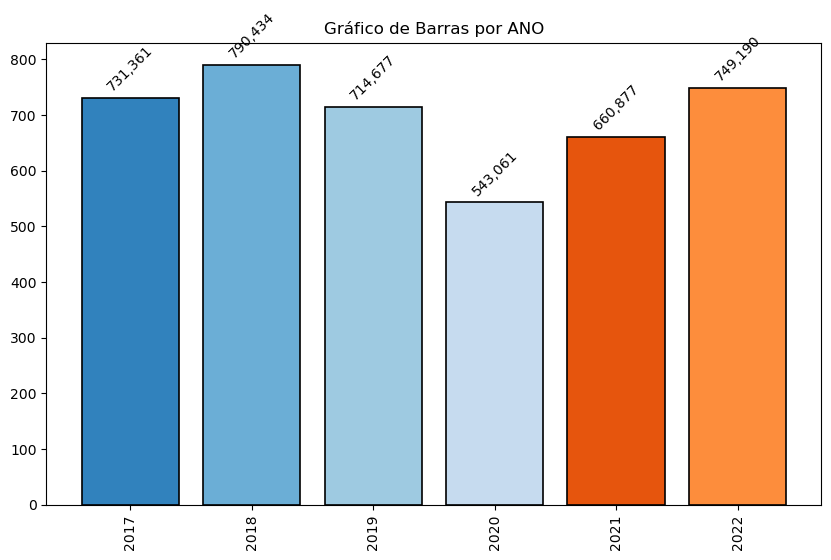

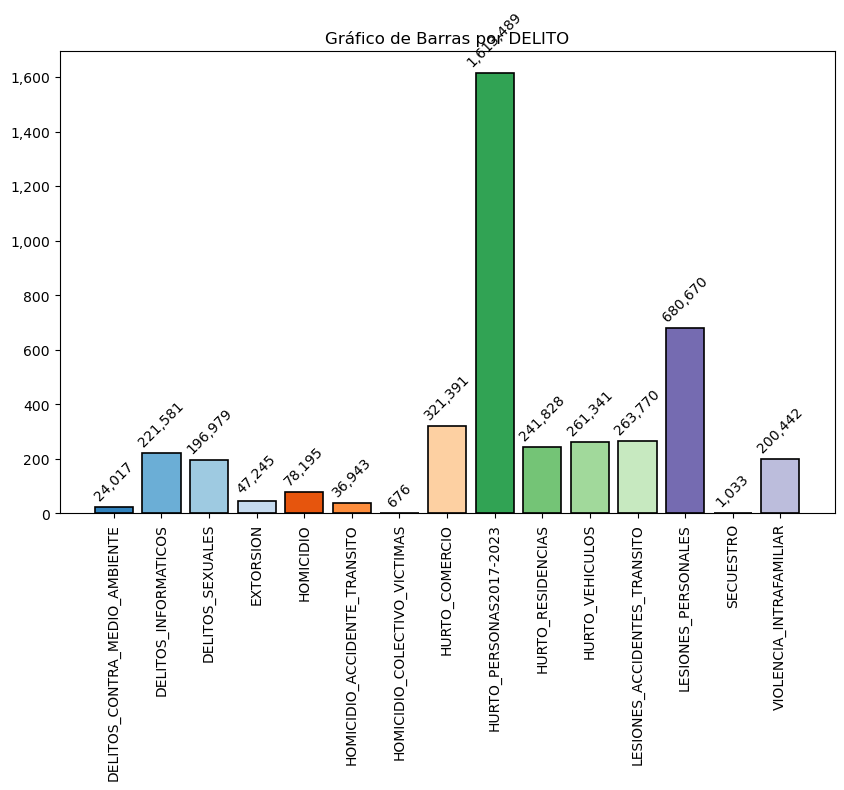

In [7]:
# Función para crear un gráfico de barras con colores degradados y bordes
# Función para formatear las etiquetas del eje y en miles

from matplotlib.ticker import FuncFormatter

def formato_miles(valor, _):
    return '{:,.0f}'.format(round(valor / 1000,0))  # Divide por 1000 para mostrar en miles

def grafico_barras(dataframe, columna):
    # Agrupar por la columna especificada y sumar las cantidades
    df_agrupado = dataframe.groupby(columna)['CANTIDAD'].sum().reset_index()

    plt.figure(figsize=(10, 6))
    colores = plt.cm.tab20c(np.arange(len(df_agrupado)))
    bars = plt.bar(df_agrupado[columna], df_agrupado['CANTIDAD'], color=colores, edgecolor='black', linewidth=1.2)
    plt.title(f'Gráfico de Barras por {columna}')
    plt.xticks(rotation=90) # Etiquetas

    for bar in bars:
        height = bar.get_height()
        plt.annotate('{:,.0f}'.format(height ), xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords='offset points', ha='center', va='bottom',rotation=45)

    # Formatear el eje y en miles
    plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles))
    plt.show()
    
data=datos_totales
grafico_barras(data, 'ANO')
grafico_barras(data, 'DELITO')

Se observa que de los últimos 6 años , el año 2020 fué el que presento menor cantidad de delitos (731.361) esto puede ser efectos de la pandemia de COVID en donde la mayoria de personas se encontraban en cuarentena la mayor parte del año, adicionalmente 2018 ha sdo el mes con mayor cantidad de delitos (790.434), sin embargo en los último 3 años del análisis se evidencia un crecimiento añoa a año.

El hurto a personas es el delito que ha afectado en gran medida a la población en los últimos años siendo la categoría con mayor participación 1.619.489, seguido de lesiiones personales con 680.670 casos.

#### Evolución de delitos en los últimos 6 años

In [8]:
# Agrupación de los datos por año y delito según su frecuencia
data_anio = datos_totales.groupby(['ANO', 'DELITO'])['CANTIDAD'].sum().reset_index()
# se pivotean los datos para reorganizar el DataFrame
data_anio = data_anio.pivot(index=['ANO'], columns='DELITO', values='CANTIDAD').reset_index()
# Cambiar el nombre de las columnas
data_anio.columns.name = None

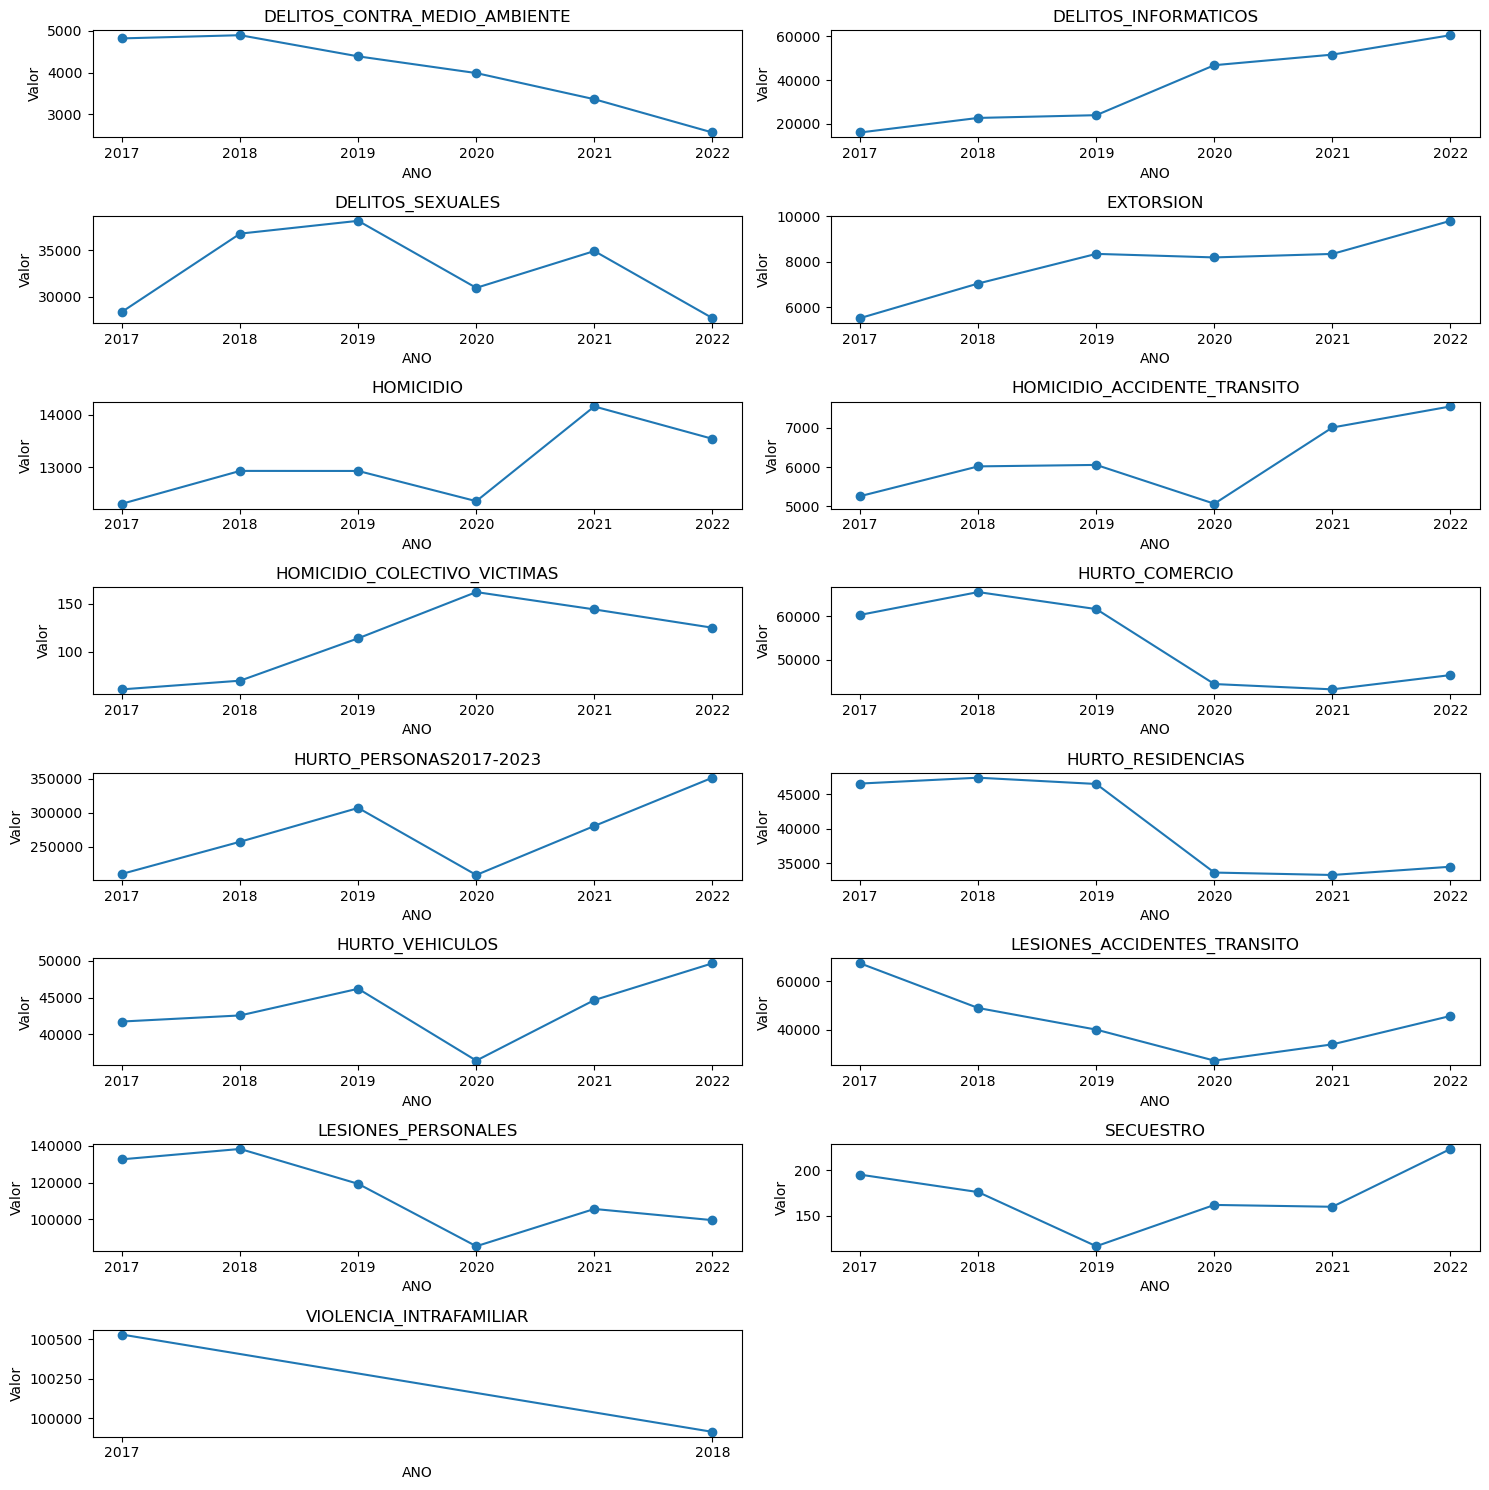

In [9]:
# Transfromación variable año a texto
data_anio['ANO'] = data_anio['ANO'].astype(str)

# Identificar las columnas de datos
columns_to_plot = data_anio.columns[1:]  # Excluye la columna 'ANO'
num_columns = len(columns_to_plot)
num_plots_per_row = 2
num_rows = (num_columns + num_plots_per_row - 1) // num_plots_per_row

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(15, 15))

for i, column in enumerate(columns_to_plot):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    ax = axes[row, col]

    ax.plot(data_anio['ANO'], data_anio[column], marker='o')
    ax.set_title(column)
    ax.set_xlabel('ANO')
    ax.set_ylabel('Valor')

# Ajustar el diseño de los subplots
for i in range(num_rows):
    for j in range(num_plots_per_row):
        if i * num_plots_per_row + j >= num_columns:
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()


En este paso se agrupan los datos totales por año y tipo de delito, para identificar el comportamiento que ha tenido cada variable al pasar los años lo que facilita el análisis de los datos totales de delitos por año, en donde se observa que los delitos contra el medio ambiente han presentado dismunición en los último años, lo contrario de los delitos informaticos y extorsión los cuales vienen creciendo. Adicionalmente se observa cómo lo vimos en el análisis anterior que todos los delito disminuyeron significativamente en el año 2020 debido a la pandemia pero a la vez se observa que posterior a este año han iso aumentando en cada periodo.

#### Estadisticas descriptivas por variable

In [10]:
df_stats=df.drop('ANO',axis=1)
df_corr = df_stats.set_index('COD_MUNI')
#2 Estadísticas descriptivas
descriptive_stats = df_corr.describe()
descriptive_stats.T

,count,mean,std,min,25%,50%,75%,max
DELITOS_CONTRA_MEDIO_AMBIENTE,6578.0,3.651110,10.438481,0.0,0.0,1.0,4.0,316.0
DELITOS_INFORMATICOS,6578.0,33.685163,425.075676,0.0,0.0,2.0,5.0,18060.0
DELITOS_SEXUALES,6578.0,29.945120,196.966015,0.0,3.0,7.0,17.0,6597.0
EXTORSION,6578.0,7.182274,46.279440,0.0,0.0,1.0,4.0,1721.0
HOMICIDIO,6578.0,11.887352,55.109249,0.0,0.0,2.0,8.0,1244.0
HOMICIDIO_ACCIDENTE_TRANSITO,6578.0,5.616145,21.406950,0.0,0.0,1.0,5.0,608.0
HOMICIDIO_COLECTIVO_VICTIMAS,6578.0,0.102767,0.835262,0.0,0.0,0.0,0.0,22.0
HURTO_COMERCIO,6578.0,48.858468,497.994878,0.0,1.0,4.0,14.0,18690.0
HURTO_PERSONAS2017-2023,6578.0,245.285649,3443.707520,0.0,2.0,7.0,27.0,137098.0
HURTO_RESIDENCIAS,6578.0,36.763150,288.670073,0.0,1.0,5.0,16.0,10021.0


En este paso se identifican las principales estadísticas descriptivas por cada tipo de delito en el periodo analizadoen donde se puede observar que los delitos contra el medio ambiente tienen un promedio de 3.65, con valores que varían desde 0 hasta 316. Los delitos informáticos tienen un promedio mucho más alto de 33.69, con un rango considerable y un valor máximo de 18.060 en donde se entiende según el análisis anterior se debe a su crecimiento en los últimos años, los delitos sexuales tienen un promedio de 29.95, con valores que van desde 0 hasta 6597 aunque ha disminuido en los últimos años. Similarmente, otros tipos de delitos tienen valores de promedio y rangos diferentes, siendo el hurto a personas y el hurto a residencias los que tienen los promedios más altos y los rangos más amplios. Sin embargo, el secuestro y el homicidio colectivo tienen promedios bajos y una gran concentración de valores en 0 ya que como se veía en las gráficas anteriores hay años en donde no se tiene infromación.

#### Correlación

,DELITOS_CONTRA_MEDIO_AMBIENTE,DELITOS_INFORMATICOS,DELITOS_SEXUALES,EXTORSION,HOMICIDIO,HOMICIDIO_ACCIDENTE_TRANSITO,HOMICIDIO_COLECTIVO_VICTIMAS,HURTO_COMERCIO,HURTO_PERSONAS2017-2023,HURTO_RESIDENCIAS,HURTO_VEHICULOS,LESIONES_ACCIDENTES_TRANSITO,LESIONES_PERSONALES,SECUESTRO,VIOLENCIA_INTRAFAMILIAR
DELITOS_CONTRA_MEDIO_AMBIENTE,1.000000,0.636157,0.701845,0.647924,0.600672,0.688196,0.167722,0.641658,0.663174,0.683169,0.606704,0.614812,0.705894,0.419350,0.394109
DELITOS_INFORMATICOS,0.636157,1.000000,0.903583,0.919933,0.712425,0.811793,0.184763,0.801469,0.910794,0.847858,0.828466,0.582140,0.838606,0.591226,0.245296
DELITOS_SEXUALES,0.701845,0.903583,1.000000,0.924164,0.830627,0.926046,0.257520,0.946844,0.962296,0.957387,0.928525,0.768857,0.963070,0.612739,0.470017
EXTORSION,0.647924,0.919933,0.924164,1.000000,0.826664,0.885611,0.222862,0.823029,0.863430,0.850212,0.918818,0.682604,0.855049,0.677870,0.293360
HOMICIDIO,0.600672,0.712425,0.830627,0.826664,1.000000,0.898971,0.303726,0.797569,0.746055,0.790783,0.885289,0.804299,0.831012,0.689240,0.449940
HOMICIDIO_ACCIDENTE_TRANSITO,0.688196,0.811793,0.926046,0.885611,0.898971,1.000000,0.250856,0.878175,0.857785,0.881404,0.930674,0.838064,0.906936,0.663998,0.482142
HOMICIDIO_COLECTIVO_VICTIMAS,0.167722,0.184763,0.257520,0.222862,0.303726,0.250856,1.000000,0.259518,0.259124,0.240596,0.235733,0.170672,0.236989,0.217298,0.052375
HURTO_COMERCIO,0.641658,0.801469,0.946844,0.823029,0.797569,0.878175,0.259518,1.000000,0.948831,0.982888,0.885939,0.796175,0.977501,0.564415,0.660083
HURTO_PERSONAS2017-2023,0.663174,0.910794,0.962296,0.863430,0.746055,0.857785,0.259124,0.948831,1.000000,0.955664,0.868422,0.693681,0.948860,0.552719,0.483592
HURTO_RESIDENCIAS,0.683169,0.847858,0.957387,0.850212,0.790783,0.881404,0.240596,0.982888,0.955664,1.000000,0.869603,0.788569,0.986599,0.570240,0.617148


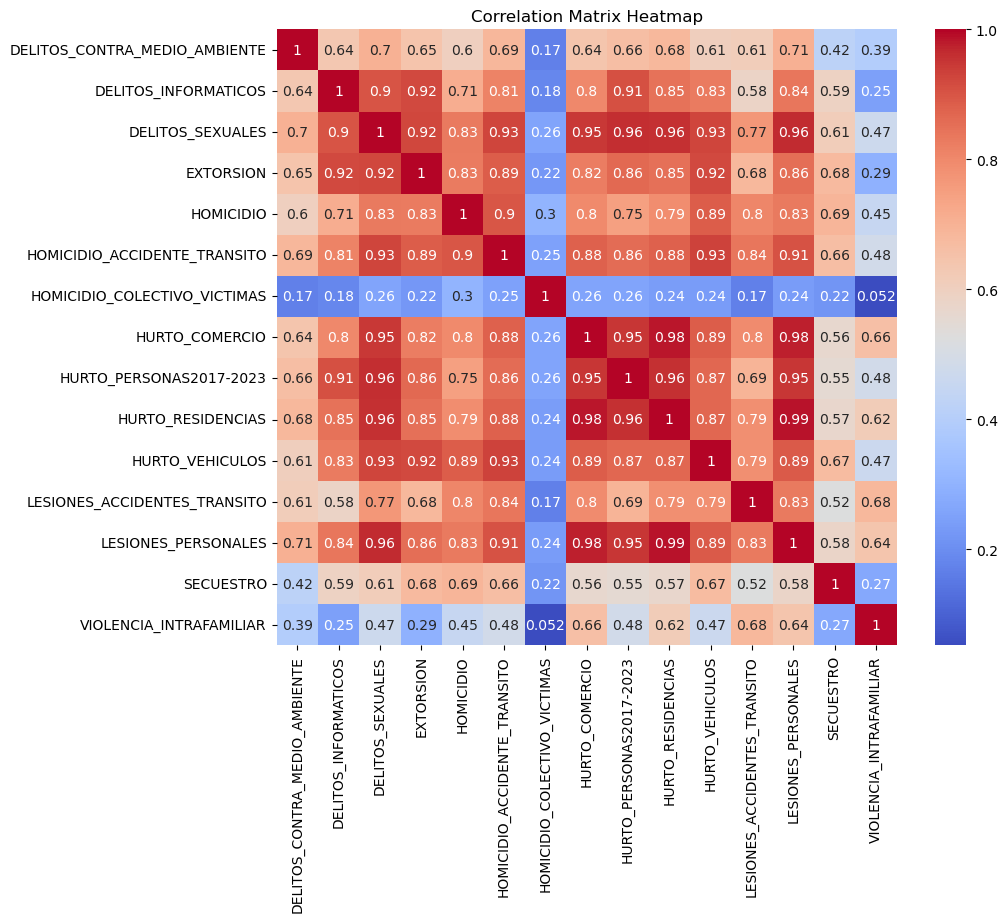

Número de gráficos a generar :136


In [11]:
#4 Matriz de correlación
df_corr2 = df.drop(columns=['ANO','COD_MUNI'])

# Calcular la matriz de correlación

correlation_matrix = df_corr2.corr()
display(correlation_matrix)

#5 mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

#6 Número de Gráficas de dispersión bivariadas
num_variables = df.shape[1] 
num_plots = num_variables * (num_variables - 1) // 2 
print('Número de gráficos a generar :'+str(num_plots))

 Se genera la matriz de correlación para identificar la magnitud y la dirección de la relación lineal entre variables, sin embargo esta se encuentra difícil de interpretar pero con esta ya podemos construir visualizaciones que permitan identificar de forma más facil las variables de alta correlación ya que al construir los gráficos deberiamos analizar 136 en total.
 
 Por lo anterior se procede a crear un mapa de calor para facilitar la descripción de la misma, en donde se observan algunas variables que presentan una correlación positiva alta.

### PCA

Se procede a aplicar Análisis de Componentes Principales (PCA) con el fin de reducir dimensionalidad en los datos. Para esto se genera por cada uno de los años, explicando la varianza acumulada y posteriormente el criterio de Kaiser, lo cual permite seleccionar con fundamentos el número de componentes principales mínimo que explica la mayor varianza del dataset original.

#### Proporción Acumulada de Varianza Explicada por año

In [12]:
#Genera análisis de componentes principales por cada uno de los años.

def analyze_data_for_values(data, target_column, values_to_filter):
    for value_to_filter in values_to_filter:
        # Filtrar el DataFrame
        filtered_df = data[data['ANO'] == value_to_filter]

        # Separar dataframe
        X = filtered_df.drop(columns=['COD_MUNI','ANO'])
        y = filtered_df['COD_MUNI']

        # Estandarizar los datos
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Calcular la varianza explicada acumulativa para diferentes números de componentes
        num_components_range = range(1, X.shape[1] + 1)
        cumulative_variance_ratios = []

        for num_components in num_components_range:
            pca = PCA(n_components=num_components)
            X_pca = pca.fit_transform(X_scaled)
            cumulative_variance_ratio = np.sum(pca.explained_variance_ratio_)
            cumulative_variance_ratios.append(cumulative_variance_ratio)

        # Crear la gráfica de la varianza explicada acumulativa
        plt.figure(figsize=(10, 6))
        plt.plot(num_components_range, cumulative_variance_ratios, marker='o', linestyle='-', color='b')
        plt.title(f'Varianza Explicada Acumulativa para Año={value_to_filter}')
        plt.xlabel('Número de Componentes Principales')
        plt.ylabel('Varianza Explicada Acumulativa')
        plt.grid(True)
        for i, j in zip(num_components_range, cumulative_variance_ratios):
            plt.annotate(f'{j:.2f}', xy=(i, j), textcoords='offset points', xytext=(0, 10), ha='center')

        plt.show()




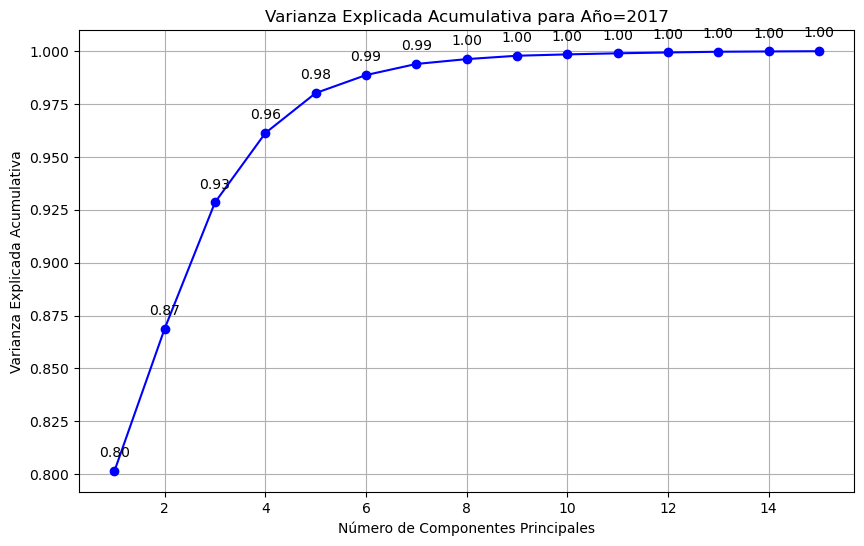

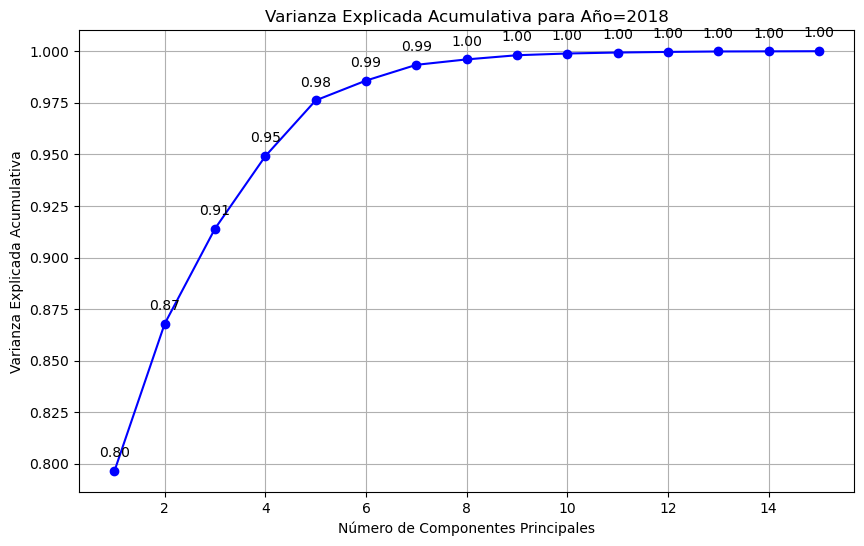

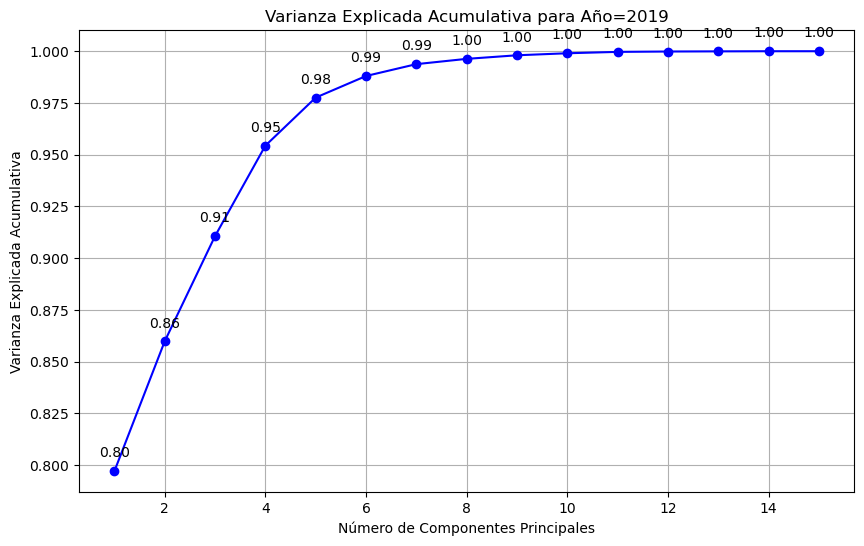

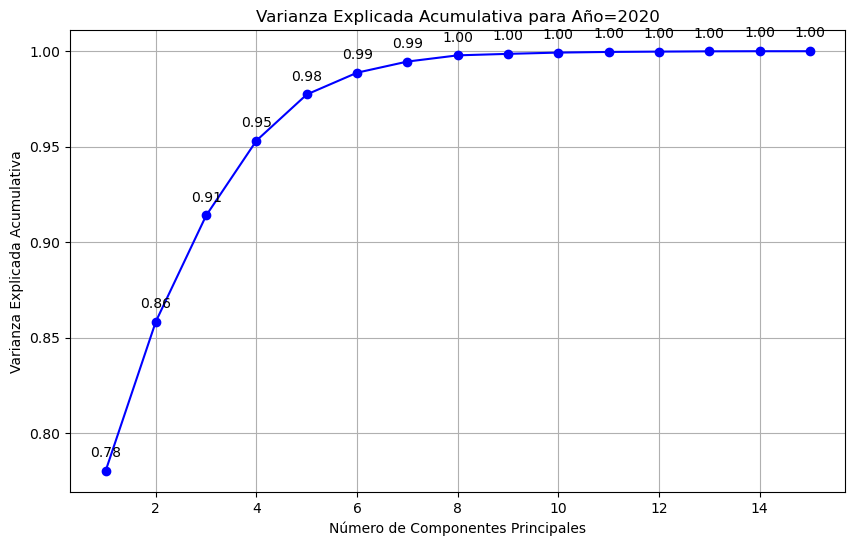

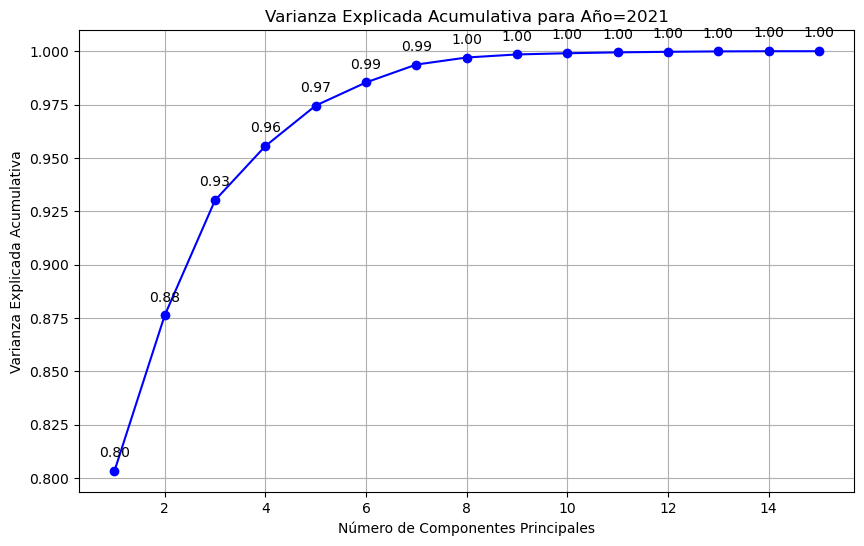

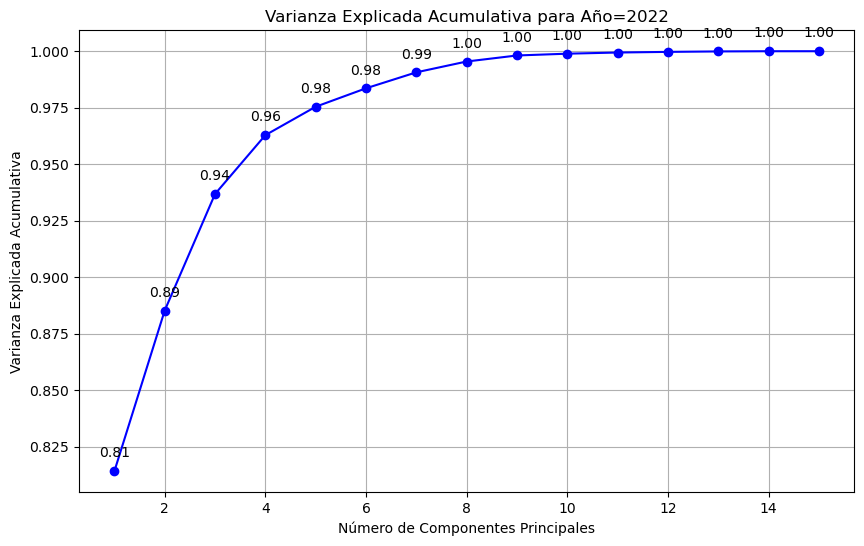

In [13]:
data=df
values_to_filter = data['ANO'].unique().tolist()
analyze_data_for_values(data, 'COD_MUNI', values_to_filter)

#### Proporción Acumulada de Varianza Explicada para 6 años de datos

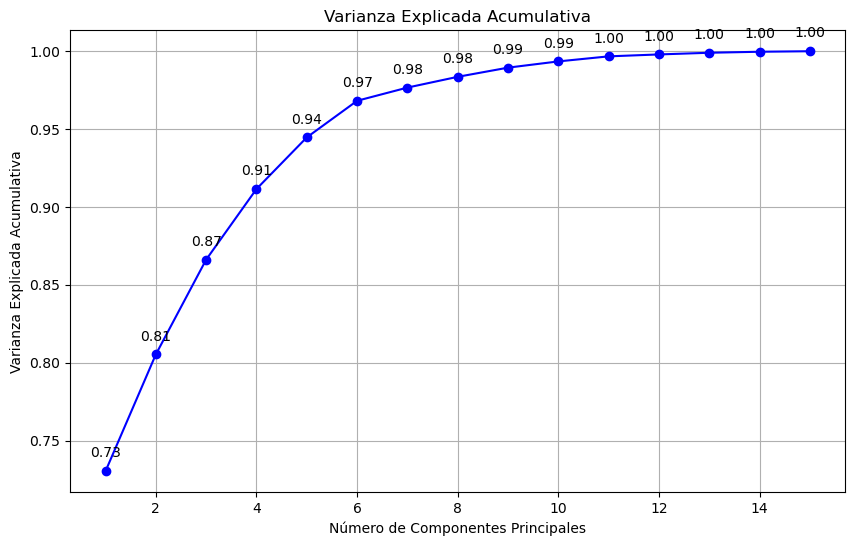

In [14]:
# Separar dataset
X = df.drop(columns=['COD_MUNI','ANO'])
y = df['COD_MUNI']
# Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Varianza Acumulada
num_components_range = range(1, X.shape[1] + 1)
cumulative_variance_ratios = []
for num_components in num_components_range:
    pca = PCA(n_components=num_components)
    X_pca = pca.fit_transform(X_scaled)
    cumulative_variance_ratio = np.sum(pca.explained_variance_ratio_)
    cumulative_variance_ratios.append(cumulative_variance_ratio)
# Graficar
plt.figure(figsize=(10, 6))
plt.plot(num_components_range, cumulative_variance_ratios, marker='o', linestyle='-', color='b')
plt.title('Varianza Explicada Acumulativa')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulativa')
plt.grid(True)
for i, j in zip(num_components_range, cumulative_variance_ratios):
    plt.annotate(f'{j:.2f}', xy=(i, j), textcoords='offset points', xytext=(0, 10), ha='center')

plt.show()


A través de la proporción de varianza explicada se busca identificar los componentes principales que nos ayude a explicar una gran parte de la variabilidad en los datos, en donde si definimos un umbral del 90% nos sugeriría utilizar 3 componentes principales en promedio para cada uno de los años.

#### Método Kaiser para cada año

Año 2017
eigenvalues de cada componente [1.20312443e+01 1.01317770e+00 8.96003463e-01 4.92274904e-01
 2.83899934e-01 1.27761856e-01 7.89042539e-02 3.43754337e-02
 2.39323906e-02 9.60225130e-03 7.72880474e-03 5.93113854e-03
 5.12601258e-03 2.10499171e-03 1.61870607e-03]


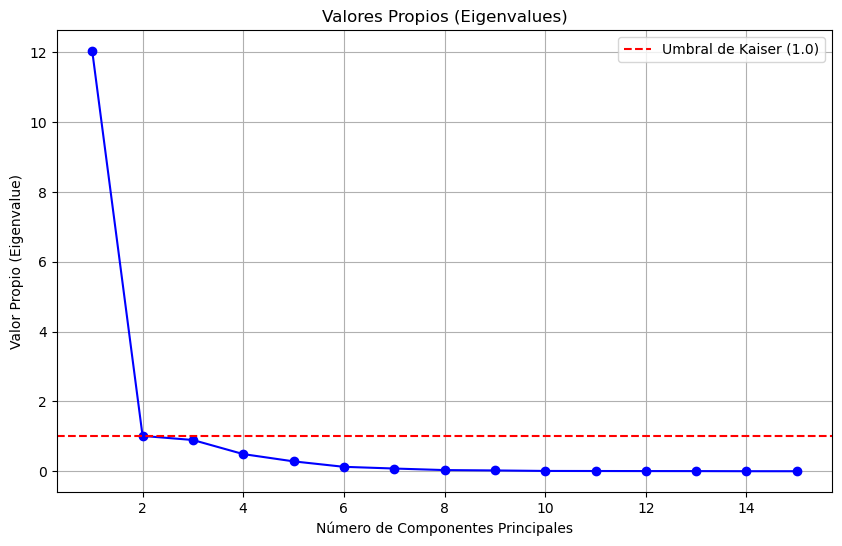

Número de componentes principales según el método de Kaiser: 2
Año 2018
eigenvalues de cada componente [1.19571266e+01 1.07343839e+00 6.92248694e-01 5.27396247e-01
 4.05634213e-01 1.44137784e-01 1.14742032e-01 3.94296790e-02
 3.03434949e-02 1.26226061e-02 7.10608398e-03 4.38701688e-03
 3.26462670e-03 9.22857482e-04 8.98305420e-04]


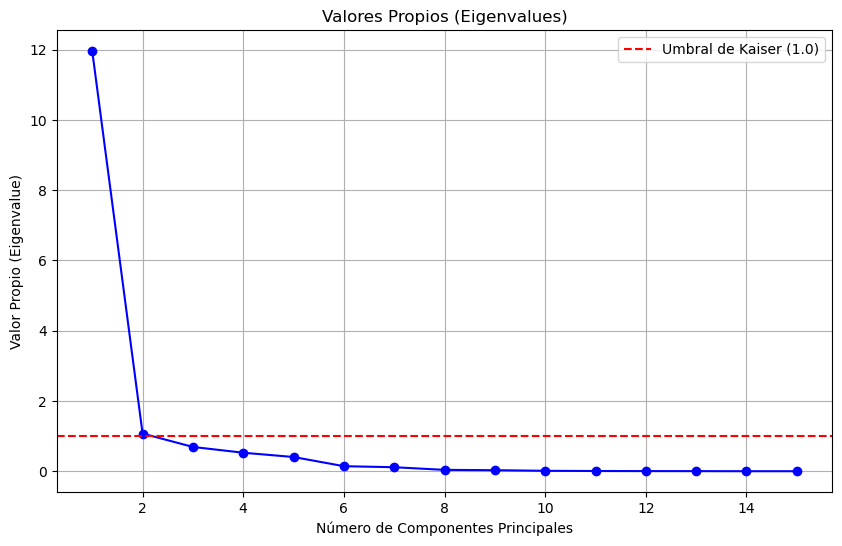

Número de componentes principales según el método de Kaiser: 2
Año 2019
eigenvalues de cada componente [1.11689777e+01 8.79494896e-01 7.12408633e-01 6.12393247e-01
 3.25416843e-01 1.46249501e-01 8.03467831e-02 3.57766694e-02
 2.42410080e-02 1.37121489e-02 9.30639117e-03 2.48616341e-03
 1.04584525e-03 9.29539280e-04 0.00000000e+00]


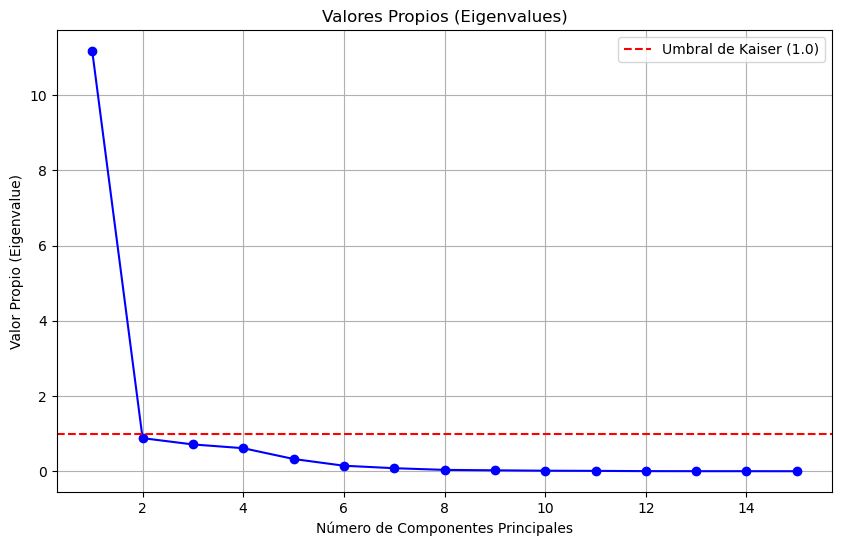

Número de componentes principales según el método de Kaiser: 1
Año 2020
eigenvalues de cada componente [1.09326950e+01 1.09745795e+00 7.77932078e-01 5.49377059e-01
 3.38360953e-01 1.59640603e-01 8.15872771e-02 4.54876296e-02
 1.09141554e-02 9.28589956e-03 4.80915311e-03 2.39076304e-03
 2.12003072e-03 7.26819422e-04 0.00000000e+00]


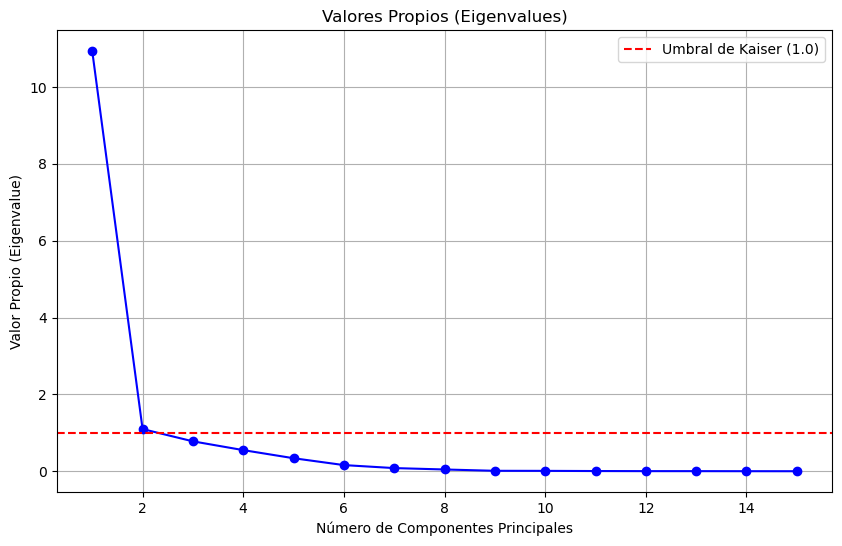

Número de componentes principales según el método de Kaiser: 2
Año 2021
eigenvalues de cada componente [1.12558022e+01 1.02298637e+00 7.55650142e-01 3.55628987e-01
 2.65870076e-01 1.51848885e-01 1.17466248e-01 4.62574305e-02
 2.01731423e-02 7.82021376e-03 5.79211769e-03 3.66066731e-03
 2.64401491e-03 1.18486192e-03 0.00000000e+00]


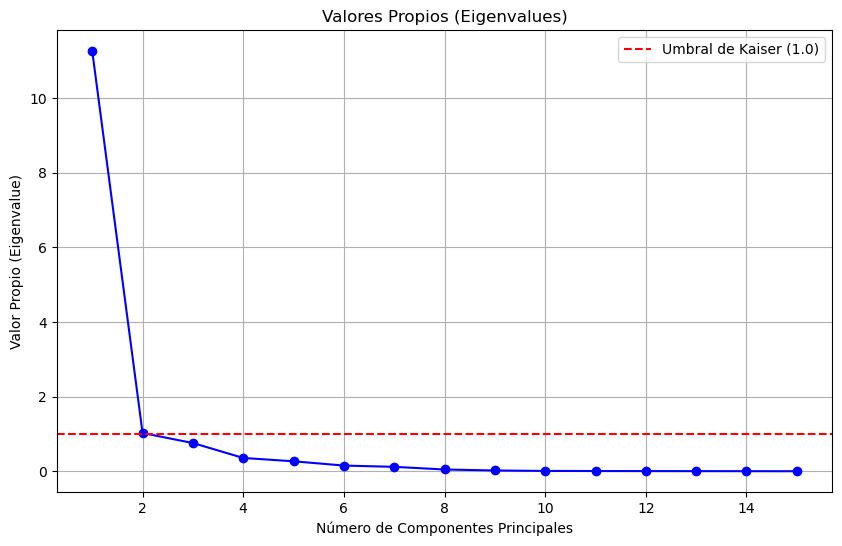

Número de componentes principales según el método de Kaiser: 2
Año 2022
eigenvalues de cada componente [1.14074989e+01 9.96620073e-01 7.22926066e-01 3.65165094e-01
 1.76198634e-01 1.14374948e-01 9.91005767e-02 6.70838584e-02
 3.73949267e-02 1.11337301e-02 7.18200109e-03 3.98753157e-03
 2.87082265e-03 1.23651927e-03 0.00000000e+00]


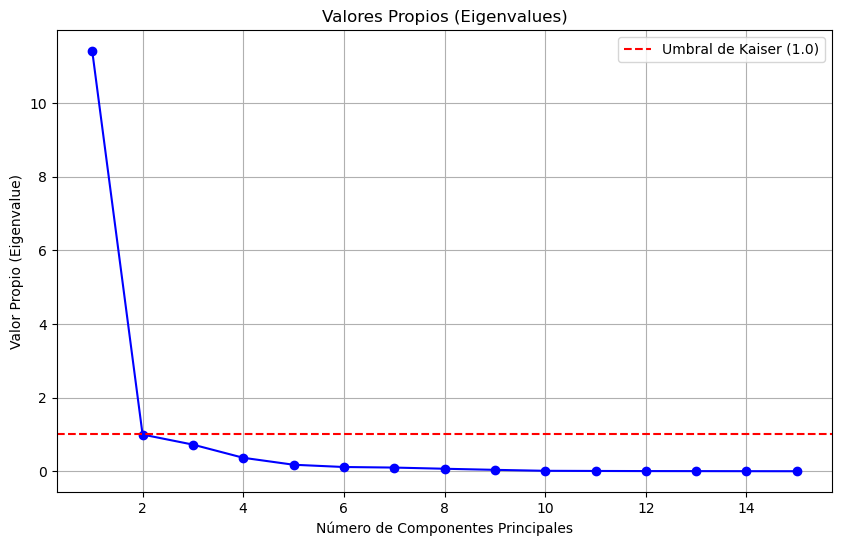

Número de componentes principales según el método de Kaiser: 1


In [15]:

values_to_filter = df['ANO'].unique().tolist()
for value_to_filter in values_to_filter:
    filtered_df = df[df['ANO'] == value_to_filter]

    # Separar dataframe
    X = filtered_df.drop(columns=['COD_MUNI','ANO'])
    y = filtered_df['COD_MUNI']

    # Estandarizar los datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Aplicar PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Calcular los valores propios
    eigenvalues = pca.explained_variance_
    print('Año '+str(value_to_filter))
    num_components_kaiser = np.sum(eigenvalues > 1.0)
    print('eigenvalues de cada componente '+str(eigenvalues))
    # Gráfica de la varianza explicada acumulativa
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-', color='b')
    plt.title('Valores Propios (Eigenvalues)')
    plt.xlabel('Número de Componentes Principales')
    plt.ylabel('Valor Propio (Eigenvalue)')
    plt.grid(True)
    
    plt.axhline(y=1.0, color='r', linestyle='--', label='Umbral de Kaiser (1.0)')

    plt.legend()
    plt.show()
    print(f"Número de componentes principales según el método de Kaiser: {num_components_kaiser}")




### Kaiser Acumulado para 6 años de datos

eigenvalues de cada componente [1.14074989e+01 9.96620073e-01 7.22926066e-01 3.65165094e-01
 1.76198634e-01 1.14374948e-01 9.91005767e-02 6.70838584e-02
 3.73949267e-02 1.11337301e-02 7.18200109e-03 3.98753157e-03
 2.87082265e-03 1.23651927e-03 0.00000000e+00]


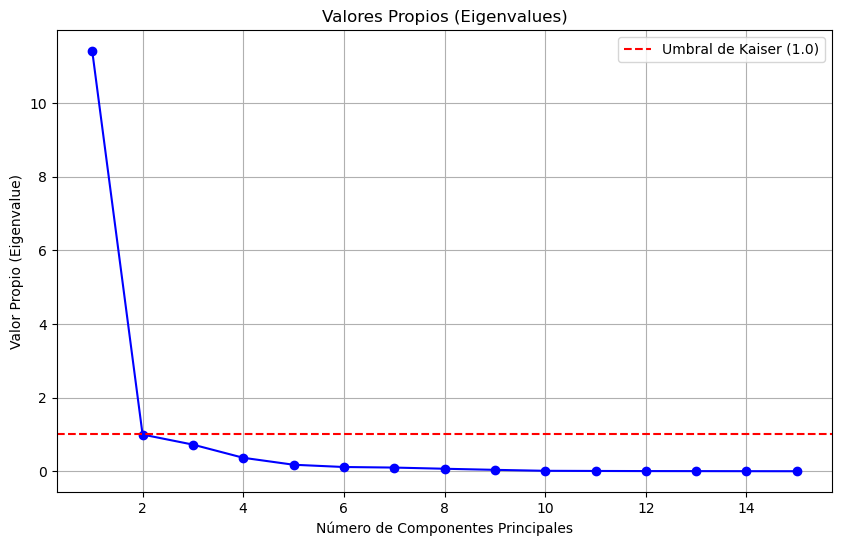

Número de componentes principales según el método de Kaiser: 1


In [16]:

# Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calcular los valores propios
eigenvalues = pca.explained_variance_

# Calcular el número de componentes principales según el método de Kaiser (valores propios > 1)
num_components_kaiser = np.sum(eigenvalues > 1.0)
print('eigenvalues de cada componente '+str(eigenvalues))
# Crear la gráfica de la varianza explicada acumulativa
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-', color='b')
plt.title('Valores Propios (Eigenvalues)')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Valor Propio (Eigenvalue)')
plt.grid(True)

# Agregar una línea para indicar el valor umbral de Kaiser (1.0)
plt.axhline(y=1.0, color='r', linestyle='--', label='Umbral de Kaiser (1.0)')

plt.legend()
plt.show()

# Mostrar el número de componentes principales según el método de Kaiser
print(f"Número de componentes principales según el método de Kaiser: {num_components_kaiser}")


El método Kaiser como  técnica utilizada en análisis de componentes principales (PCA)es otra forma de identificar cuántos componentes principales podriamos tomar de nuestro conjunto de datos en donde se basa en que solo se deberían retener los componentes o factores cuyos valores propios (eigenvalues) sean mayores que 1, ya que estos explican más varianza que una única variable original. Para nuestros datos se obtiene como resultado año a año un promedio de 2 PCA.

#### Interpretación de los componentes principales. 

In [17]:
df_2019=df[df['ANO']==2019]
# Separar dataframe
X = df_2019.drop(columns=['COD_MUNI','ANO'])
y = df_2019['COD_MUNI'] 

# Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
n_components=3
# Aplicar PCA
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

selected_components = []

for i in range(n_components):
    component_loadings = pca.components_[i]
    feature_names = X.columns
    component_info = [f'{component_loadings[j]:.3f} {feature_names[j]}' for j in range(len(feature_names))]
    selected_components.append(component_info)

for i, component_info in enumerate(selected_components):
    print(f"\033[1mPC:\033[0m {i + 1}") 
    print(' + '.join(component_info))


PC: 1
0.170 DELITOS_CONTRA_MEDIO_AMBIENTE + 0.289 DELITOS_INFORMATICOS + 0.296 DELITOS_SEXUALES + 0.287 EXTORSION + 0.271 HOMICIDIO + 0.291 HOMICIDIO_ACCIDENTE_TRANSITO + 0.219 HOMICIDIO_COLECTIVO_VICTIMAS + 0.290 HURTO_COMERCIO + 0.283 HURTO_PERSONAS2017-2023 + 0.291 HURTO_RESIDENCIAS + 0.283 HURTO_VEHICULOS + 0.237 LESIONES_ACCIDENTES_TRANSITO + 0.294 LESIONES_PERSONALES + 0.197 SECUESTRO + -0.000 VIOLENCIA_INTRAFAMILIAR
PC: 2
0.368 DELITOS_CONTRA_MEDIO_AMBIENTE + -0.216 DELITOS_INFORMATICOS + -0.042 DELITOS_SEXUALES + 0.187 EXTORSION + 0.269 HOMICIDIO + 0.144 HOMICIDIO_ACCIDENTE_TRANSITO + -0.461 HOMICIDIO_COLECTIVO_VICTIMAS + -0.204 HURTO_COMERCIO + -0.282 HURTO_PERSONAS2017-2023 + -0.162 HURTO_RESIDENCIAS + 0.166 HURTO_VEHICULOS + 0.535 LESIONES_ACCIDENTES_TRANSITO + -0.106 LESIONES_PERSONALES + -0.058 SECUESTRO + -0.000 VIOLENCIA_INTRAFAMILIAR
PC: 3
0.785 DELITOS_CONTRA_MEDIO_AMBIENTE + -0.072 DELITOS_INFORMATICOS + -0.077 DELITOS_SEXUALES + -0.087 EXTORSION + -0.085 HOMICIDIO + 

Como se muestra anteriormente, teniendo en cuenta los datos para el año 2019, se tiene este grupo de 3 componentes principales, de los cuales destacan en cada uno los delitos de:
> PCA1:

    * DELITOS_SEXUALES
    * LESIONES_PERSONALES
    * HOMICIDIO_ACCIDENTE_TRANSITO
    
> PCA2:

    * DELITOS_CONTRA_MEDIO_AMBIENTE
    * LESIONES_ACCIDENTES_TRANSITO 
    * HOMICIDIO_COLECTIVO_VICTIMAS 
> PCA3:

    * DELITOS_CONTRA_MEDIO_AMBIENTE 
    * SECUESTRO 
    * HOMICIDIO_COLECTIVO_VICTIMAS 

## Clustering

### K means

In [18]:
df_2021=df[df['ANO']==2021]
df_2021

,COD_MUNI,ANO,DELITOS_CONTRA_MEDIO_AMBIENTE,DELITOS_INFORMATICOS,DELITOS_SEXUALES,EXTORSION,HOMICIDIO,HOMICIDIO_ACCIDENTE_TRANSITO,HOMICIDIO_COLECTIVO_VICTIMAS,HURTO_COMERCIO,HURTO_PERSONAS2017-2023,HURTO_RESIDENCIAS,HURTO_VEHICULOS,LESIONES_ACCIDENTES_TRANSITO,LESIONES_PERSONALES,SECUESTRO,VIOLENCIA_INTRAFAMILIAR
4,5001,2021,28.0,3773.0,2622.0,636.0,405.0,353.0,0.0,3251.0,23625.0,1665.0,5679.0,1063.0,4884.0,9.0,0.0
10,5002,2021,0.0,6.0,15.0,3.0,2.0,3.0,0.0,8.0,8.0,15.0,4.0,3.0,38.0,0.0,0.0
16,5004,2021,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
22,5021,2021,2.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,3.0,3.0,0.0,0.0,16.0,0.0,0.0
28,5030,2021,8.0,13.0,26.0,5.0,20.0,4.0,0.0,10.0,32.0,13.0,14.0,12.0,62.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6552,97666,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,6.0,0.0,0.0
6558,99001,2021,4.0,9.0,30.0,4.0,6.0,1.0,0.0,4.0,35.0,20.0,7.0,1.0,51.0,0.0,0.0
6564,99524,2021,0.0,2.0,8.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,4.0,0.0,7.0,0.0,0.0
6570,99624,2021,0.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,1.0,0.0,11.0,0.0,0.0


In [19]:
#Lee datos de coordenada por municipio
path = os.path.join(path, 'coordenadas_municipios.xlsx')

coordenadas=pd.read_excel(path)
df=datos_totales
result = df_2021.merge(coordenadas, on='COD_MUNI', how='left')

In [20]:
df_coordenadas=result
df_coordenadas.drop_duplicates(subset='COD_MUNI')

,COD_MUNI,ANO,DELITOS_CONTRA_MEDIO_AMBIENTE,DELITOS_INFORMATICOS,DELITOS_SEXUALES,EXTORSION,HOMICIDIO,HOMICIDIO_ACCIDENTE_TRANSITO,HOMICIDIO_COLECTIVO_VICTIMAS,HURTO_COMERCIO,HURTO_PERSONAS2017-2023,HURTO_RESIDENCIAS,HURTO_VEHICULOS,LESIONES_ACCIDENTES_TRANSITO,LESIONES_PERSONALES,SECUESTRO,VIOLENCIA_INTRAFAMILIAR,Nombre,Longitud,Latitud
0,5001,2021,28.0,3773.0,2622.0,636.0,405.0,353.0,0.0,3251.0,23625.0,1665.0,5679.0,1063.0,4884.0,9.0,0.0,MEDELLÍN,-75.591602,6.252777
1,5002,2021,0.0,6.0,15.0,3.0,2.0,3.0,0.0,8.0,8.0,15.0,4.0,3.0,38.0,0.0,0.0,ABEJORRAL,-75.465670,5.766286
2,5004,2021,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,ABRIAQUÍ,-76.077048,6.653143
3,5021,2021,2.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,3.0,3.0,0.0,0.0,16.0,0.0,0.0,ALEJANDRÍA,-75.141346,6.376061
4,5030,2021,8.0,13.0,26.0,5.0,20.0,4.0,0.0,10.0,32.0,13.0,14.0,12.0,62.0,0.0,0.0,AMAGÁ,-75.700878,6.051654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,97666,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,6.0,0.0,0.0,TARAIRA,-69.634271,-0.566224
1096,99001,2021,4.0,9.0,30.0,4.0,6.0,1.0,0.0,4.0,35.0,20.0,7.0,1.0,51.0,0.0,0.0,PUERTO CARREÑO,-68.116838,5.998079
1097,99524,2021,0.0,2.0,8.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,4.0,0.0,7.0,0.0,0.0,LA PRIMAVERA,-69.938952,5.792084
1098,99624,2021,0.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,1.0,0.0,11.0,0.0,0.0,SANTA ROSALÍA,-70.948908,4.994927


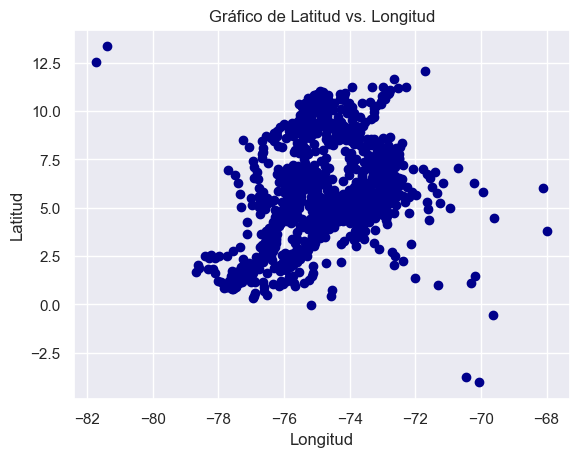

In [21]:
#gráfico de los datos
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans
plt.scatter(df_coordenadas['Longitud'], df_coordenadas['Latitud'], color='darkblue')
plt.title('Gráfico de Latitud vs. Longitud')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

In [24]:
# !pip install folium
import folium

mapa = folium.Map(location=[4.673245059408865, -74.10068230291301], zoom_start=5, title='Mapa de Municipios Colombia')  #Bogotá
for index, row in df_coordenadas.iterrows():
    folium.Marker([row['Latitud'], row['Longitud']], popup=row['Nombre']).add_to(mapa)
mapa.save('mapa.html')
print("\033[1mMapa de Municipios en Colombia en que se han cometido delitos en el año 2021:\033[0m")
mapa

Mapa de Municipios en Colombia en que se han cometido delitos en el año 2021:


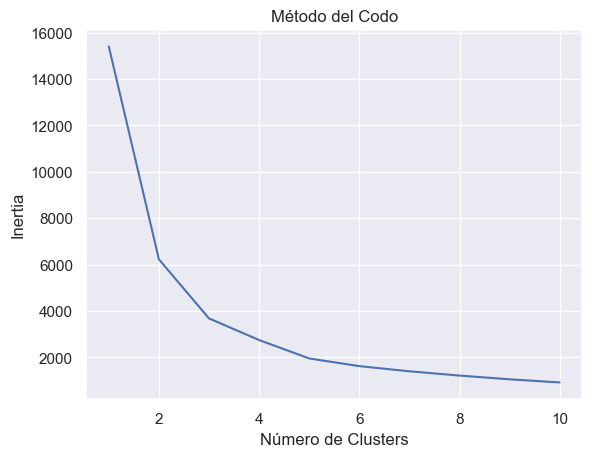

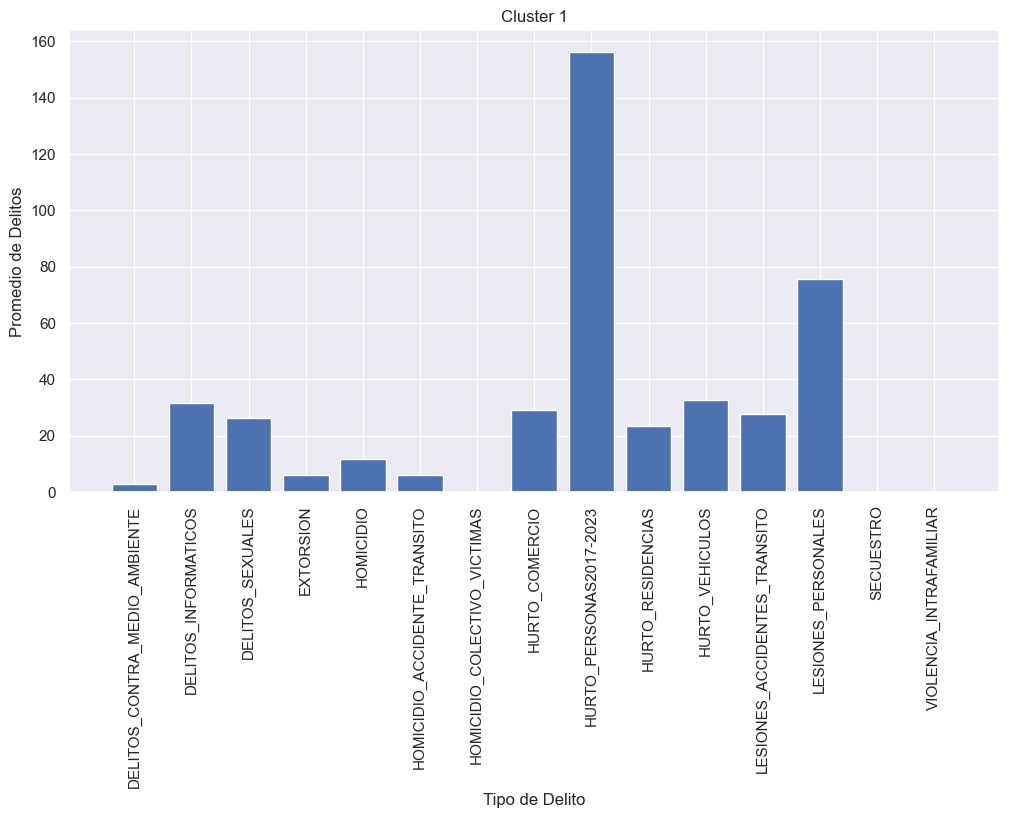

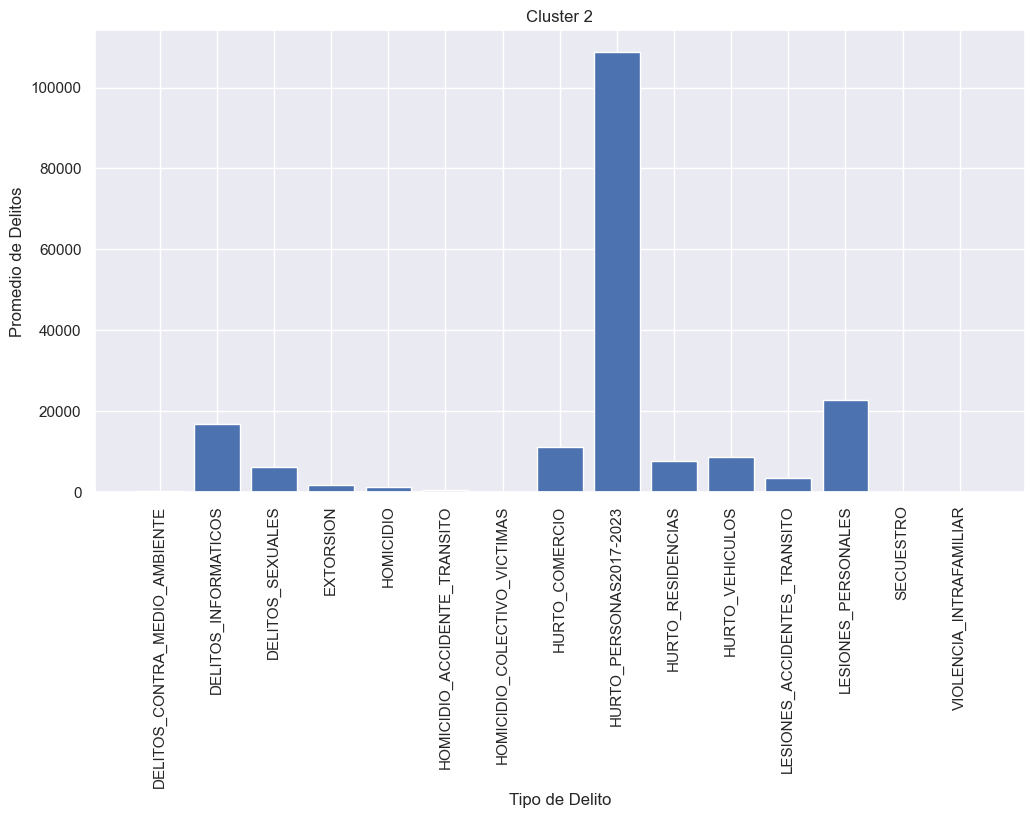

Coeficiente de Silueta: 0.9841996205899413


In [33]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
data = df_coordenadas 

# delitos
features = data[['DELITOS_CONTRA_MEDIO_AMBIENTE', 'DELITOS_INFORMATICOS', 'DELITOS_SEXUALES',
                 'EXTORSION', 'HOMICIDIO', 'HOMICIDIO_ACCIDENTE_TRANSITO', 'HOMICIDIO_COLECTIVO_VICTIMAS',
                 'HURTO_COMERCIO', 'HURTO_PERSONAS2017-2023', 'HURTO_RESIDENCIAS', 'HURTO_VEHICULOS',
                 'LESIONES_ACCIDENTES_TRANSITO', 'LESIONES_PERSONALES', 'SECUESTRO', 'VIOLENCIA_INTRAFAMILIAR']]

# Normalizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

# Determinar el número óptimo de clusters utilizando el método del codo
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.title('Método del Codo')
plt.show()

#num clusters
k = 2

# Aplicar K-Means
kmeans = KMeans(n_clusters=k, random_state=0)
cluster_labels = kmeans.fit_predict(scaled_data)

# Agregar las etiquetas de cluster al DataFrame original
data['Cluster'] = cluster_labels

cluster_stats = data.groupby('Cluster').mean()
centers = kmeans.cluster_centers_

for i in range(k):
    plt.figure(figsize=(12, 6))
    plt.bar(features.columns, cluster_stats.loc[i, features.columns])
    plt.xlabel('Tipo de Delito')
    plt.ylabel('Promedio de Delitos')
    plt.title(f'Cluster {i + 1}')
    plt.xticks(rotation=90)
    plt.show()

silhouette_avg = silhouette_score(scaled_data, cluster_labels)
print(f'Coeficiente de Silueta: {silhouette_avg}')


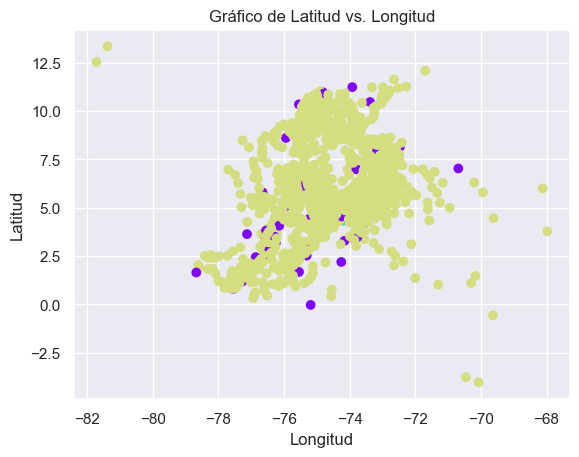

In [32]:
#Gráficar Clusters sugeridos

plt.scatter(data['Longitud'], data['Latitud'],c=data['Cluster'], cmap = 'rainbow')
plt.title('Gráfico de Latitud vs. Longitud')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

Luego de realizar el análisis de clustering con k-means sin utilizar componentes principales para reducir la dimensionalidad, para tener una primera vista con los datos de entrada, se puede observar que sugiere dos clusters gracias al coeficiente de silueta con un valor de 0.98.

## Conclusiones:
* Una vez realizado la etapa descriptiva se evidencia que hay un volumen significativamente menor o sin existencia de delitos, además de un volumen muy alto del delito HURTO_PERSONAS2017-2023, esto afecta directamente al análisis, ya que al no tener en cuenta las densidades poblacionales una estandarización de los datos no tiene mucho efecto en el tratamiento de los mismos, por ende para una entrega posterior se hará enfasís en generar una tasa de ocurrencia en relación a la población de cada municipio.
* Utilizando el algoritmo de PCA para reducir dimensionalidad también se pueden agrupar estos delitos en componentes con el fin de hacer el análisis final más acotado.
* Se evaluarán otros modelos de clusterización al igual que se tendrá en cuenta el análisis de PCA para incluir y acotar de mejor manera los clusters resultantes.
* Una vez se puedan identificar por medio de PCA y clustering los municipios y zonas que más incidencia por grupo de delitos tienen se plasmará los resultados geográficamente con el fin de identificar las zonas calientes por cada grupo de delito.
